In [45]:
suppressMessages(suppressWarnings(library(tidyverse)))
library('metap')
library("qvalue")

ERROR: Error in library("qvalue"): there is no package called 'qvalue'


In [46]:
max_min <- function(x,type){
if (type=="max"){
return (max(as.double(x),na.rm = TRUE))   
}
else if (type=="min") {
return (min(as.double(x),na.rm = TRUE))    
}  
}

In [47]:
top_quartile <- function(x,type){
if (type=="max"){
return (summary(as.double(x))[5])    
}
else if (type=="min") {
return (summary(as.double(x))[2])    
}  
}

In [48]:
avg_p <- function(x,type){
if (type=="max"){
return (mean(as.double(x),na.rm =TRUE))   
}
else if (type=="min") {
return (allmetap(na.omit(x),method="sumlog")$p)   
}  
}

In [49]:
### Load hg19 gene,TSS information

In [50]:
gene_annotation<- read.table("../../ANALYSIS/gene_annot_jun10.txt",header=T)

In [51]:
head(gene_annotation)

,ENSGID,NAME,CHR,START,END,TSS
,<chr>,<chr>,<int>,<int>,<int>,<int>
1,ENSG00000186092,OR4F5,1,69091,70008,69091
2,ENSG00000235249,OR4F29,1,367640,368634,367640
3,ENSG00000185097,OR4F16,1,621059,622053,622053
4,ENSG00000187634,SAMD11,1,860260,879955,860260
5,ENSG00000188976,NOC2L,1,879584,894689,894689
6,ENSG00000187961,KLHL17,1,895967,901095,895967


In [52]:
## Trans

In [53]:
trans_lead <- read.table("../../ANALYSIS/TRANSANCESTRY_LEAD.TAB",header=T)

In [54]:
#gene to variant mapping

In [55]:
gene_variant <- data.frame()

for (i in 1:nrow(trans_lead) ){
   
line_q <- trans_lead[i,]
marker_q <- as.character(line_q[1])
chr_q <- as.integer(line_q[2])
start_q<- as.integer(line_q[6])
end_q <- as.integer(line_q[7])
lead_q <- as.integer(line_q[5])
position_q <- as.integer(line_q[3])
tmp_df <- gene_annotation%>%filter(CHR==chr_q & START >= start_q & END <= end_q)%>%mutate(INDEX=marker_q,WINDOW=lead_q,POSITION=position_q,TSS_DISTANCE=abs(TSS-POSITION))
gene_variant <- rbind(gene_variant,tmp_df)
}

In [56]:
###MAGMA

In [57]:
trans_magma <- read.table("../../ANALYSIS/POPS/TRANS_MAGMA.genes.out",header=T)%>%rename(ENSGID=GENE)
gene_variant_1 <- merge(gene_variant,trans_magma,by="ENSGID")%>%select(ENSGID,NAME,CHR.x,START.x,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,P)%>%rename(CHR=CHR.x,START=START.x,MAGMA_P=P)

In [58]:
head(gene_variant_1)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,6.5270e-03
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,1.0485e-09
3,ENSG00000006047,YBX2,17,7191571,7197934,7197934,rs222852,21,7140606,57328,1.3405e-09
4,ENSG00000008405,CRY1,12,107385142,107487607,107487607,rs10778506,16,107143260,344347,1.3150e-07
5,ENSG00000010318,PHF7,3,52444673,52457657,52444673,rs1108842,4,52720080,275407,2.0069e-11
6,ENSG00000010319,SEMA3G,3,52467069,52479101,52479101,rs1108842,4,52720080,240979,1.6328e-11


In [59]:
## Colocalization

In [60]:
trans_coloc <- read.table("../../ANALYSIS/COLOC_SUSIE/TRANS_ANCESTRY_COLOC_H4.TAB",header=T)%>%rename(ENSGID=Probe)%>%select(ENSGID,Tissue,H4_abf)

In [61]:
#trans_coloc_2 <- read.table("../../ANALYSIS/GTEX/TRANS_EQTL_OVERLAPS.txt",header=T)
#trans_coloc_2 <- merge(gene_variant_1,trans_coloc_2,by="NAME")%>%select(ENSGID,Tissue,H4_abf)
#trans_coloc <- rbind(trans_coloc_1,trans_coloc_2)

In [62]:
##max-min

In [63]:
gene_variant_2<- data.frame()
for (i in 1:nrow(gene_variant_1) ){
line_q <- gene_variant_1[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(trans_coloc%>%filter(ENSGID==ensg_q))
if (genep>0){
c_df <- trans_coloc%>%filter(ENSGID==ensg_q)%>%select(Tissue,H4_abf)%>%mutate(weight = case_when(grepl("Artery|Adipose|Heart", Tissue) ~ "1",TRUE ~ '0.8'))
pip_coloc <- max(c_df$H4_abf)
coloc_weight <- max(as.double((c_df%>%filter(H4_abf==pip_coloc))$weight))
}else {
pip_coloc <- 0
coloc_weight <- 0
}
tmp_df <- gene_variant_1[i,]%>%mutate(coloc_pip=pip_coloc,coloc_WT=coloc_weight)
gene_variant_2 <- rbind(gene_variant_2,tmp_df)
}

In [64]:
head(gene_variant_2)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P,coloc_pip,coloc_WT
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,6.5270e-03,0.0000000,0.0
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,1.0485e-09,0.0000000,0.0
3,ENSG00000006047,YBX2,17,7191571,7197934,7197934,rs222852,21,7140606,57328,1.3405e-09,0.5262069,0.8
4,ENSG00000008405,CRY1,12,107385142,107487607,107487607,rs10778506,16,107143260,344347,1.3150e-07,0.0000000,0.0
5,ENSG00000010318,PHF7,3,52444673,52457657,52444673,rs1108842,4,52720080,275407,2.0069e-11,0.0000000,0.0
6,ENSG00000010319,SEMA3G,3,52467069,52479101,52479101,rs1108842,4,52720080,240979,1.6328e-11,0.0000000,0.0


In [65]:
##SMR

In [66]:
trans_smr <- read.table("../../ANALYSIS/SMR//Trans_ancestry_SMR.tab",header=T)%>%rename(ENSGID=probeID)

In [67]:
gene_variant_3 <- data.frame()
for (i in 1:nrow(gene_variant_2) ){
line_q <- gene_variant_2[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(trans_smr%>%filter(ENSGID==ensg_q))
if (genep>0){
smr_df <- trans_smr%>%filter(ENSGID==ensg_q)%>%select(filename,p_SMR)%>%mutate(weight_smr = case_when(grepl("Artery|Adipose|Heart", filename) ~ "1",TRUE ~ '0.8'))
p_smr <- min(smr_df$p_SMR)
smr_weight <- max(as.double((smr_df%>%filter(p_SMR==p_smr))$weight_smr))
}else {
p_smr <- NA
smr_weight <-0 
}
tmp_df <- gene_variant_2[i,]%>%mutate(p_SMR=p_smr,SMR_WT=smr_weight)
gene_variant_3 <- rbind(gene_variant_3,tmp_df)
}


In [68]:
head(gene_variant_3)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P,coloc_pip,coloc_WT,p_SMR,SMR_WT
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,6.5270e-03,0.0000000,0.0,NA,0.0
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,1.0485e-09,0.0000000,0.0,NA,0.0
3,ENSG00000006047,YBX2,17,7191571,7197934,7197934,rs222852,21,7140606,57328,1.3405e-09,0.5262069,0.8,7.094827e-06,0.8
4,ENSG00000008405,CRY1,12,107385142,107487607,107487607,rs10778506,16,107143260,344347,1.3150e-07,0.0000000,0.0,NA,0.0
5,ENSG00000010318,PHF7,3,52444673,52457657,52444673,rs1108842,4,52720080,275407,2.0069e-11,0.0000000,0.0,NA,0.0
6,ENSG00000010319,SEMA3G,3,52467069,52479101,52479101,rs1108842,4,52720080,240979,1.6328e-11,0.0000000,0.0,NA,0.0


In [69]:
## eQTL overlaps

In [70]:
trans_eqtl <- read.table("../../ANALYSIS/GTEX/TRANS_EQTL_OVERLAPS.txt",fill=TRUE,row.names=NULL,header=TRUE)

In [71]:
gene_variant_4 <- data.frame()
for (i in 1:nrow(gene_variant_3) ){
line_q <- gene_variant_3[i,]
ensg_q <- as.character(line_q[2])
genep<- nrow(trans_eqtl%>%filter(Transcript==ensg_q))
if (genep>0){
smr_df <- trans_eqtl%>%filter(Transcript==ensg_q)%>%select(Tissue,P_EQTL)%>%mutate(weight_lookup = case_when(grepl("Artery|Adipose|Heart", Tissue) ~ "1",TRUE ~ '0.8'))
p_smr <- min(smr_df$P_EQTL)
smr_weight <- max(as.double((smr_df%>%filter(P_EQTL==p_smr))$weight_lookup))
}else {
p_smr <- NA
smr_weight <-0 
}
tmp_df <- gene_variant_3[i,]%>%mutate(P_EQTL=p_smr,EQTL_WT=smr_weight)
gene_variant_4 <- rbind(gene_variant_4,tmp_df)
}


In [72]:
head(gene_variant_4,1)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P,coloc_pip,coloc_WT,p_SMR,SMR_WT,P_EQTL,EQTL_WT
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,0.006527,0,0,NA,0,NA,0


In [73]:
gene_variant_4%>%filter(NAME=="ADIPOQ")

ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P,coloc_pip,coloc_WT,p_SMR,SMR_WT,P_EQTL,EQTL_WT
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000181092,ADIPOQ,3,186560463,186576252,186560463,rs17366568,5,186570453,9990,1.4544e-14,0,1,NA,0,1.1e-14,1


In [74]:
### LDSC(Expression modifier Score)

In [75]:
trans_ldsc <- read.table("../../ANALYSIS/GTEX/TRANS_LDSC_RESULTS.TAB",fill=TRUE,row.names=NULL,header=TRUE)

In [76]:
head(trans_ldsc,2)

,GENE,Enrichment_p,Coefficient_z_score,Tissue,TSS
,<chr>,<dbl>,<dbl>,<chr>,<int>
1,AHCYL1,0.449643,0.7574982,Whole_Blood,110527308
2,AHCYL1,0.449643,0.7574982,Kidney_Cortex,110527308


In [77]:
gene_variant_5 <- data.frame()
for (i in 1:nrow(gene_variant_4) ){
line_q <- gene_variant_4[i,]
ensg_q <- as.character(line_q[2])
genep<- nrow(trans_ldsc%>%filter(GENE==ensg_q))
if (genep>0){
ldsc_df <- trans_ldsc%>%filter(GENE==ensg_q)%>%select(Tissue,Enrichment_p)%>%mutate(weight_ldsc = case_when(grepl("Artery|Adipose|Heart", Tissue) ~ "1",TRUE ~ '0.8'))
p_ldsc <- min(ldsc_df$Enrichment_p)
smr_weight <- max(as.double((ldsc_df%>%filter(Enrichment_p==p_ldsc))$weight_ldsc))
}else {
p_ldsc <- NA
smr_weight <-0 
}
tmp_df <- gene_variant_4[i,]%>%mutate(LDSC_P=p_ldsc,LDSC_WT=smr_weight)
gene_variant_5 <- rbind(gene_variant_5,tmp_df)
}


In [78]:
head(gene_variant_5)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,MAGMA_P,coloc_pip,coloc_WT,p_SMR,SMR_WT,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,6.5270e-03,0.0000000,0.0,NA,0.0,NA,0,0.626449957,1
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,1.0485e-09,0.0000000,0.0,NA,0.0,NA,0,0.000110552,1
3,ENSG00000006047,YBX2,17,7191571,7197934,7197934,rs222852,21,7140606,57328,1.3405e-09,0.5262069,0.8,7.094827e-06,0.8,NA,0,NA,0
4,ENSG00000008405,CRY1,12,107385142,107487607,107487607,rs10778506,16,107143260,344347,1.3150e-07,0.0000000,0.0,NA,0.0,NA,0,0.084596732,1
5,ENSG00000010318,PHF7,3,52444673,52457657,52444673,rs1108842,4,52720080,275407,2.0069e-11,0.0000000,0.0,NA,0.0,NA,0,NA,0
6,ENSG00000010319,SEMA3G,3,52467069,52479101,52479101,rs1108842,4,52720080,240979,1.6328e-11,0.0000000,0.0,NA,0.0,NA,0,0.002939900,1


In [79]:
##EMS overlaps

In [80]:
trans_ems <- read.table("../../ANALYSIS/EMS_OVERLAP/TRANS_OVERLAP_EMS.TAB",fill=TRUE,row.names=NULL,header=TRUE)

In [81]:
head(trans_ems,2)

,CHROMOSOME,POSITION,GENE,EMS_N,Tissue,scaled_EMS
,<int>,<int>,<chr>,<dbl>,<chr>,<dbl>
1,1,10003457,ENSG00000173614,3017000,Artery_Coronary,0.3031811
2,1,10003457,ENSG00000173614,7680000,Heart_Atrial_Appendage,0.7718478


In [82]:
gene_variant_6 <- data.frame()
for (i in 1:nrow(gene_variant_5) ){
line_q <- gene_variant_5[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(trans_ems%>%filter(GENE==ensg_q))
if (genep>0){
ems_df <- trans_ems%>%filter(GENE==ensg_q)%>%select(Tissue,scaled_EMS)%>%mutate(weight_ems = case_when(grepl("Artery|Adipose|Heart", Tissue) ~ "1",TRUE ~ '0.8'))
s_ems <- max(ems_df$scaled_EMS)
ems_weight <- max(as.double((ems_df%>%filter(scaled_EMS==s_ems))$weight_ems))
}else {
s_ems <- 0
ems_weight <-0 
}
tmp_df <- gene_variant_5[i,]%>%mutate(EMS_SCORE=s_ems,EMS_WT=ems_weight)
gene_variant_6 <- rbind(gene_variant_6,tmp_df)
}

In [83]:
head(gene_variant_6,2)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,coloc_pip,coloc_WT,p_SMR,SMR_WT,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,⋯,0,0,NA,0,NA,0,0.626449957,1,0.0000000,0
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,⋯,0,0,NA,0,NA,0,0.000110552,1,0.7718478,1


In [84]:
### POPS
stand01 <- function(x){(x-min(x,na.rm = TRUE))/(max(x,na.rm = TRUE)-min(x,na.rm = TRUE))}

In [85]:
pops_ems <- read.table("../../ANALYSIS/POPS/TRANS_POPS.txt",fill=TRUE,row.names=NULL,header=TRUE)%>%mutate(POPS=stand01(PoPS_score))

In [86]:
head(pops_ems,2)

,ENSG,GENE,PoPS_score,POPS
,<chr>,<chr>,<dbl>,<dbl>
1,ENSG00000031698,SARS,0.1608348,0.5342267
2,ENSG00000064703,DDX20,-0.8479503,0.2839632


In [87]:
gene_variant_7 <- data.frame()
for (i in 1:nrow(gene_variant_6) ){
line_q <- gene_variant_6[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(pops_ems%>%filter(ENSG==ensg_q))
if (genep>0){
pops_df <- pops_ems%>%filter(ENSG==ensg_q)%>%select(POPS)
pops_score <- as.double(pops_df)
}else {
pops_score <- 0 
}
tmp_df <- gene_variant_6[i,]%>%mutate(POPS_SCORE=pops_score)
gene_variant_7 <- rbind(gene_variant_7,tmp_df)
}

In [88]:
head(gene_variant_7,2)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,coloc_WT,p_SMR,SMR_WT,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,⋯,0,NA,0,NA,0,0.626449957,1,0.0000000,0,0.4911776
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,⋯,0,NA,0,NA,0,0.000110552,1,0.7718478,1,0.4984750


In [89]:
## DOWNSTREAMER

In [90]:
down_df <- read.table("../../ANALYSIS/DOWNSTREAMER//TRANS_Downstreamer.txt",fill=TRUE,row.names=NULL,header=TRUE)%>%mutate(DOWNSTREAMER_P=pnorm(q=ZSCORE, lower.tail=TRUE))

In [91]:
head(down_df,2)

,ENSG,NAME,ZSCORE,DOWNSTREAMER_P
,<chr>,<chr>,<dbl>,<dbl>
1,ENSG00000135698,MPHOSPH6,0.5106511,0.695202306
2,ENSG00000140945,CDH13,-2.4247364,0.007659754


In [92]:
gene_variant_8 <- data.frame()
for (i in 1:nrow(gene_variant_7) ){
line_q <- gene_variant_7[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(down_df%>%filter(ENSG==ensg_q))
if (genep>0){
downs_df <- down_df%>%filter(ENSG==ensg_q)%>%select(DOWNSTREAMER_P)
p_down <- min(downs_df$DOWNSTREAMER_P)
}else {
p_down <- NA
}
tmp_df <- gene_variant_7[i,]%>%mutate(DOWN_P=p_down)
gene_variant_8 <- rbind(gene_variant_8,tmp_df)
}

In [93]:
gene_variant_8%>%filter(NAME=="ADIPOQ")

ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,p_SMR,SMR_WT,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000181092,ADIPOQ,3,186560463,186576252,186560463,rs17366568,5,186570453,9990,⋯,NA,0,1.1e-14,1,0.0883593,1,0.02929795,0.8,0.5534483,0.3806506


In [94]:
## Epi MAp

In [95]:
epi_map <- read.table("../../ANALYSIS/EPIMAP//EPIMAP.tab",fill=TRUE,row.names=NULL,header=TRUE)

In [96]:
head(epi_map,2)

,gene,score,group
,<chr>,<chr>,<chr>
1,ENSG00000008128,0.0882523589664035,Adipose
2,ENSG00000078808,0.0823467903667026,Adipose


In [97]:
gene_variant_9 <- data.frame()
for (i in 1:nrow(gene_variant_8) ){
line_q <- gene_variant_8[i,]
ensg_q <- as.character(line_q[1])
genep<- nrow(epi_map%>%filter(gene==ensg_q))
if (genep>0){
epi_df <- epi_map%>%filter(gene==ensg_q)%>%select(score)
epi_score <- max(epi_df$score)
}else {
epi_score <- 0
}
tmp_df <- gene_variant_8[i,]%>%mutate(EPIMAP_SCORE=epi_score)
gene_variant_9 <- rbind(gene_variant_9,tmp_df)
}

In [98]:
gene_variant_9%>%filter(NAME=="CSF1")

ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,SMR_WT,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P,EPIMAP_SCORE
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000184371,CSF1,1,110452864,110473614,110452864,rs333947,1,110470764,17900,⋯,1,1.3e-19,1,0.4198435,1,0.09607518,0.8,0.607029,0.3668719,0.953864627414279


In [99]:
## Genehancer

In [100]:
gh <- read.table("../../ANALYSIS/GeneHancer/GENEHANCER.TAB",fill=TRUE,row.names=NULL,header=TRUE)%>%mutate(CHROM=as.integer(om))%>%rename(START=name,END=start,SCORE=end)%>%
select(-om)%>%mutate(SCORE=stand01(SCORE))

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"


In [101]:
head(gh,2)

,START,END,SCORE,CHROM
,<int>,<int>,<dbl>,<int>
1,133518045,133518161,0.00617284,6
2,51630569,51633727,0.24691358,13


In [102]:
gene_variant_10 <- data.frame()
for (i in 1:nrow(gene_variant_9) ){
line_q <- gene_variant_9[i,]
chr_q <- as.integer(line_q[3])
start_q<- as.integer(line_q[4])
end_q <- as.integer(line_q[5])
genep<- nrow(gh%>%filter(CHROM==chr_q & START >= start_q & END <= end_q))
if (genep>0){
gh_df <- gh%>%filter(CHROM==chr_q & START >= start_q & END <= end_q)%>%select(SCORE)
gh_score <- max(gh_df$SCORE)
}else {
gh_score <- 0
}
tmp_df <- gene_variant_9[i,]%>%mutate(GH_SCORE=gh_score)
gene_variant_10 <- rbind(gene_variant_10,tmp_df)
}

In [103]:
write.table(gene_variant_10,"../../ANALYSIS/GeneHancer/TRANS_GENEHANCER.TAB",quote=FALSE,sep="\t")

In [104]:
gene_variant_10%>%filter(NAME=="ADIPOQ")

ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,P_EQTL,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P,EPIMAP_SCORE,GH_SCORE
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
ENSG00000181092,ADIPOQ,3,186560463,186576252,186560463,rs17366568,5,186570453,9990,⋯,1.1e-14,1,0.0883593,1,0.02929795,0.8,0.5534483,0.3806506,0.416221218865092,0.5740741


In [105]:
## CS2GO SCORE

In [106]:
cs2g <- read.table("../../ANALYSIS/cS2G/TRANS_CS2G.TAB",fill=TRUE,row.names=NULL,header=TRUE)

In [107]:
head(cs2g,2)

,CHROMOSOME,POSITION,GENENAME,SCORE,INFO
,<int>,<int>,<chr>,<dbl>,<chr>
1,4,96437606,UNC5C,1.0,|Roadmap=1|PCHiC_Jung=1|ABC=1
2,18,46361441,SMAD7,0.5,|PCHiC_Javierre=1|PCHiC_Jung=1|Cicero=1


In [108]:
gene_variant_11 <- data.frame()
for (i in 1:nrow(gene_variant_10) ){
line_q <- gene_variant_10[i,]
ensg_q <- as.character(line_q[2])
genep<- nrow(cs2g%>%filter(GENENAME==ensg_q))
if (genep>0){
cs2g_df <- cs2g%>%filter(GENENAME==ensg_q)%>%select(SCORE)
score <- max(cs2g_df$SCORE)
}else {
score <- NA
}
tmp_df <- gene_variant_10[i,]%>%mutate(CS2G_SCORE=score)
gene_variant_11 <- rbind(gene_variant_11,tmp_df)
}

In [109]:
head(gene_variant_11)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P,EPIMAP_SCORE,GH_SCORE,CS2G_SCORE
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,⋯,0,0.626449957,1,0.0000000,0.0,0.4911776,NA,0.262037256868874,0.1327160,0.005
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,⋯,0,0.000110552,1,0.7718478,1.0,0.4984750,0.9634051,0.843654039833281,0.4413580,1.000
3,ENSG00000006047,YBX2,17,7191571,7197934,7197934,rs222852,21,7140606,57328,⋯,0,NA,0,0.7718478,1.0,0.4997579,0.3052930,0.739828457192677,0.1975309,1.000
4,ENSG00000008405,CRY1,12,107385142,107487607,107487607,rs10778506,16,107143260,344347,⋯,0,0.084596732,1,0.0000000,0.0,0.5450225,0.6342621,0.336853981018066,0.2098765,NA
5,ENSG00000010318,PHF7,3,52444673,52457657,52444673,rs1108842,4,52720080,275407,⋯,0,NA,0,0.4434896,0.8,0.5064670,0.9426803,0.412455677986145,0.6759259,0.800
6,ENSG00000010319,SEMA3G,3,52467069,52479101,52479101,rs1108842,4,52720080,240979,⋯,0,0.002939900,1,0.0000000,0.0,0.5125703,0.3892531,0.936377247174581,0.1481481,0.930


In [110]:
colnames(gene_variant_11)

[1] "ENSGID"       "NAME"         "CHR"          "START"        "END"         
 [6] "TSS"          "INDEX"        "WINDOW"       "POSITION"     "TSS_DISTANCE"
[11] "MAGMA_P"      "coloc_pip"    "coloc_WT"     "p_SMR"        "SMR_WT"      
[16] "P_EQTL"       "EQTL_WT"      "LDSC_P"       "LDSC_WT"      "EMS_SCORE"   
[21] "EMS_WT"       "POPS_SCORE"   "DOWN_P"       "EPIMAP_SCORE" "GH_SCORE"    
[26] "CS2G_SCORE"

In [111]:
head(gene_variant_11,2)

,ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P,EPIMAP_SCORE,GH_SCORE,CS2G_SCORE
,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,ENSG00000004700,RECQL,12,21621845,21654603,21654603,rs11045172,14,20470221,1184382,⋯,0,0.626449957,1,0.0000000,0,0.4911776,NA,0.262037256868874,0.132716,0.005
2,ENSG00000004975,DVL2,17,7128660,7137864,7137864,rs222852,21,7140606,2742,⋯,0,0.000110552,1,0.7718478,1,0.4984750,0.9634051,0.843654039833281,0.441358,1.000


In [112]:
length(na.omit(gene_variant_11$POPS_SCORE))

[1] 679

In [113]:
gene_variant_11%>%filter(NAME=="CSF1")

ENSGID,NAME,CHR,START,END,TSS,INDEX,WINDOW,POSITION,TSS_DISTANCE,⋯,EQTL_WT,LDSC_P,LDSC_WT,EMS_SCORE,EMS_WT,POPS_SCORE,DOWN_P,EPIMAP_SCORE,GH_SCORE,CS2G_SCORE
<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
ENSG00000184371,CSF1,1,110452864,110473614,110452864,rs333947,1,110470764,17900,⋯,1,0.4198435,1,0.09607518,0.8,0.607029,0.3668719,0.953864627414279,0.1728395,1


In [114]:
## GENE PRIORITY SCORE

In [115]:
library('metap')

In [116]:
gene_priority <- data.frame()
for (i in 1:nrow(gene_variant_11) ){
line_q <- gene_variant_11[i,] 
p_g_raw <- na.omit(c(line_q$MAGMA_P,line_q$p_SMR,line_q$P_EQTL,line_q$LDSC_P,line_q$DOWN_P))
if (length(p_g_raw)<2){
p_g <- p_g_raw
} else {
p_g <- -log10(as.double(allmetap(p_g_raw,method="sumz")$p))}
S_G <- sum(as.double(na.omit(c(line_q$coloc_pip,line_q$EMS_SCORE,line_q$POPS_SCORE,line_q$EPIMAP_SCORE,line_q$GH_SCORE,line_q$CS2G_SCORE))))
C_S <- sum(as.double(na.omit(c(line_q$coloc_WT,line_q$SMR_WT,line_q$EQTL_WT,line_q$LDSC_WT,line_q$EMS_WT)))+
           length(as.double(na.omit(line_q$MAGMA_P,line_q$POPS_SCORE,line_q$DOWN_P,line_q$EPIMAP_SCORE,line_q$GH_SCORE,line_q$CS2G_SCORE))))/11
GP_SCORE <- ((as.double(p_g)+as.double(S_G))*as.double(C_S))/log2(line_q$TSS_DISTANCE)
tmp_df <- gene_variant_11[i,]%>%mutate(GP_SCORE=as.double(GP_SCORE),P_G=p_g,SG=S_G,CS=C_S)
gene_priority  <- rbind(gene_priority,tmp_df)
}

In [117]:
gene_priority <- arrange(gene_priority%>%group_by(WINDOW)%>% mutate(mx = max(GP_SCORE)) %>% arrange(desc(mx), desc(GP_SCORE)) %>% select(-mx),CHR,POSITION)%>%
select(NAME,CHR,POSITION,INDEX,GP_SCORE,TSS_DISTANCE,P_G,SG,CS,MAGMA_P,p_SMR,P_EQTL,LDSC_P,DOWN_P,coloc_pip,EMS_SCORE,POPS_SCORE,GH_SCORE,CS2G_SCORE,coloc_WT,SMR_WT,EQTL_WT,LDSC_WT,EMS_WT)

Adding missing grouping variables: `WINDOW`


In [118]:
normalit<-function(m){
   (m - mean(m))/(sd(m))
 }

In [119]:
## reli imp

In [120]:
suppressWarnings(suppressMessages(library('relaimpo')))
df <- gene_priority%>%group_by(WINDOW)%>% mutate(CS2G_SCORE = ifelse(is.na(CS2G_SCORE), 0, CS2G_SCORE))%>%mutate(TSS_norm=normalit(log2(TSS_DISTANCE)),PG=normalit(P_G),CSN=normalit(CS),SGN=normalit(SG))
df_csf1 <- df%>%filter(WINDOW==1)
df1 <- df%>%group_by(WINDOW) %>%do( gpcontrib= (calc.relimp(lm(GP_SCORE ~  TSS_norm+ PG + CSN+ SGN, data = .),rela = TRUE))$lmg)
df2<- read.table("../../ANALYSIS/TRANSANCESTRY_WINDOW_GENE.txt",header=TRUE)
df3 <- merge(df,df1,by="WINDOW")
df4 <- merge(df3,df2,by="WINDOW")
df5<-unnest(df4%>%dplyr::select(gpcontrib,GENE)%>%distinct())
write.table(df5,"../../ANALYSIS/PAPER/Figures/stackedplot_data.txt",quote=FALSE)

Warning message:
"`cols` is now required when using unnest().
Please use `cols = c(gpcontrib)`"


In [121]:
##

In [122]:
write.table(gene_priority,"../../ANALYSIS/GENE_PRIORITY/TRANS_GPSCORE.TAB",row.names=FALSE,quote=FALSE,sep="\t")

In [84]:
df10<- gene_priority%>%filter(WINDOW==1) %>%mutate(TSS_norm=normalit(log2(TSS_DISTANCE)),PG=normalit(P_G),CSN=normalit(CS),SGN=normalit(SG))%>%dplyr::select(NAME,TSS_norm,PG,CSN,SGN,GP_SCORE)

Adding missing grouping variables: `WINDOW`


In [86]:
df11 <- df10%>%ungroup()%>% slice_max(order_by = GP_SCORE, n = 15)%>% pivot_longer(cols=c('TSS_norm', 'PG','CSN','SGN'),
                    names_to='GPTerm',
                    values_to='value')%>%dplyr::select(-WINDOW)

In [87]:
head(df11)

NAME,GP_SCORE,GPTerm,value
<chr>,<dbl>,<chr>,<dbl>
CSF1,1.3351294,TSS_norm,-3.848824
CSF1,1.3351294,PG,4.829563
CSF1,1.3351294,CSN,3.643085
CSF1,1.3351294,SGN,2.429850
AHCYL1,0.5983399,TSS_norm,-2.538050
AHCYL1,0.5983399,PG,2.594779


In [94]:
install.packages('gghighlight')

Installing package into 'C:/Users/svish/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'gghighlight' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\svish\AppData\Local\Temp\RtmpOAtbAO\downloaded_packages


In [90]:
options(repr.plot.width=15, repr.plot.height=7.5)
suppressWarnings(suppressMessages(library(viridis)))
library(hrbrthemes)
p <- ggplot(df11, aes(NAME,GPTerm, fill= value)) + 
  geom_tile(color="gray")  +
  scale_fill_viridis(discrete=FALSE) +
  theme_ipsum()

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

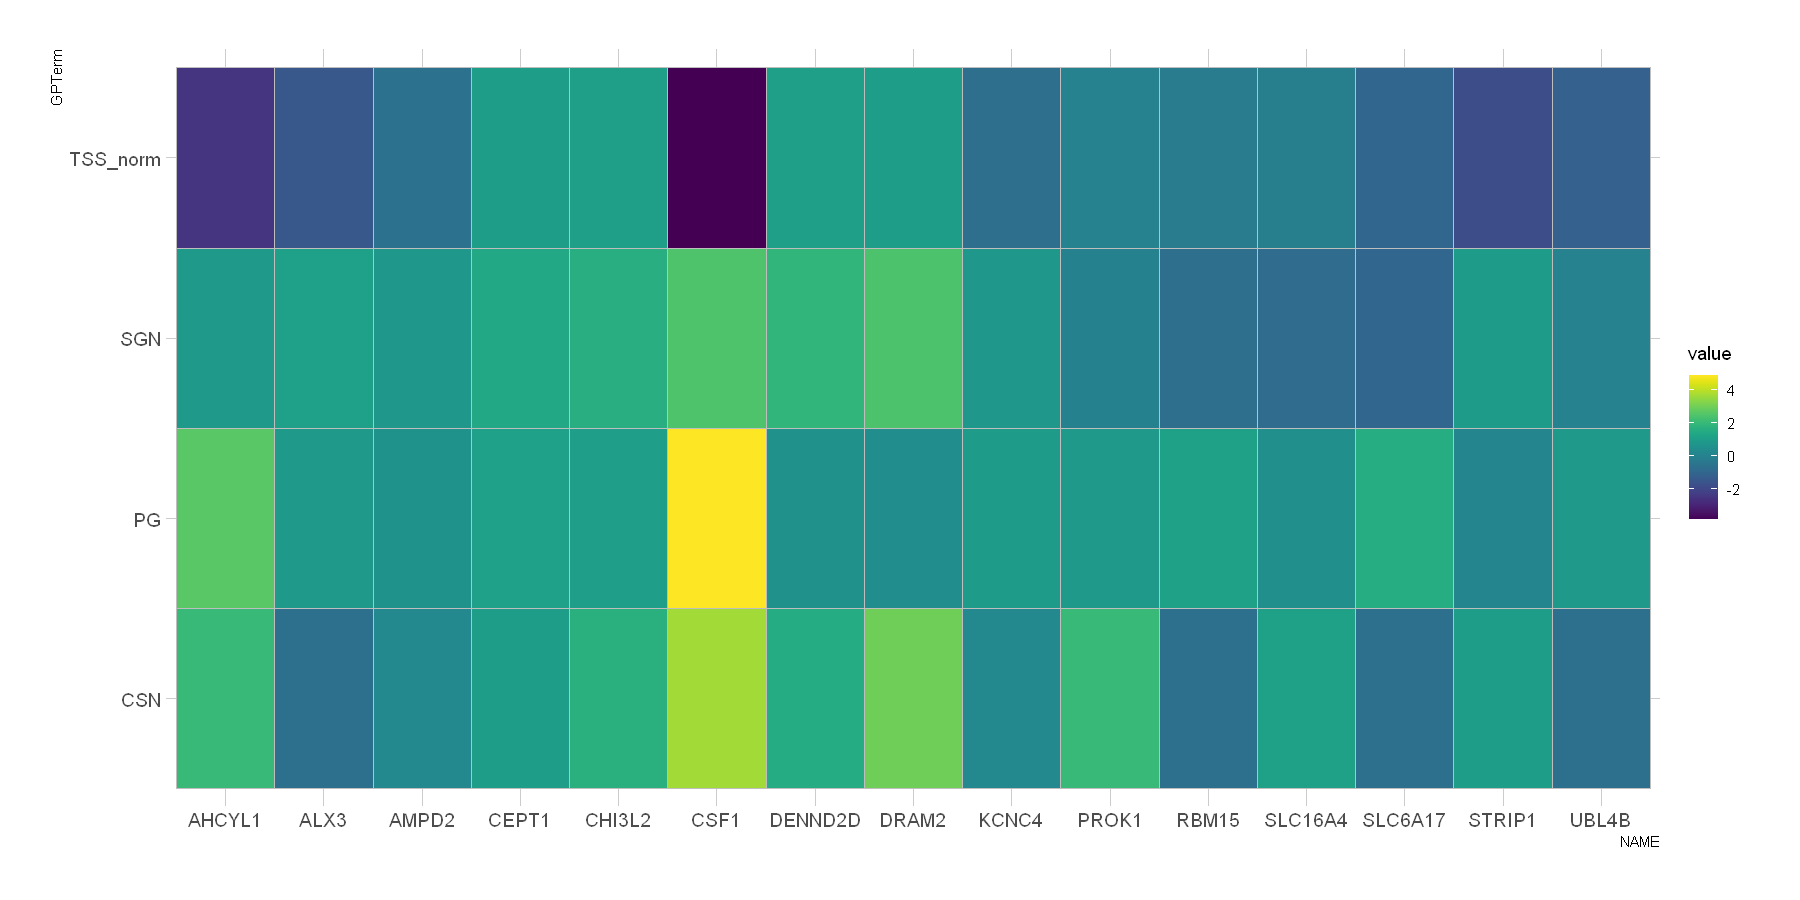

In [91]:
p

In [175]:
ggsave(filename = "../../../ANALYSIS/PAPER/Figures/Fig6c.pdf", device = "pdf",  plot = p, width = 10, height =6 , dpi = 600, units = "in")

Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
"font family 'Arial Narrow' not found in PostScript font database"
Warning message in g

ERROR: Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, : invalid font type


In [149]:
genes <- c("CYP2R1","CSF1","LYPLAL1","IRS1","PBRM1","GNL3","ADIPOQ","RFC4","NAP1L5","FAM13A","FST","VEGFA","RGS17","TRIB1","ADRB1","PDE3A","RBMS2",
           "FGFR2","RIC8B","CCDC92","DNAH10OS","ZNF664","CMIP","CDH13","CTDNEP1","ELP5","PEPD","CEBPG")

In [113]:
gene_priority%>%ungroup()%>% mutate(GP_quartile = ntile(GP_SCORE, 100))%>%mutate(PG_quartile = ntile(P_G, 100))%>%mutate(SG_quartile = ntile(SG, 100))%>%mutate(CS_quartile = ntile(CS, 100))%>%filter(NAME %in% genes)

WINDOW,NAME,CHR,POSITION,INDEX,GP_SCORE,TSS,P_G,SG,CS,...,CS2G_SCORE,coloc_WT,SMR_WT,EQTL_WT,LDSC_WT,EMS_WT,GP_quartile,PG_quartile,SG_quartile,CS_quartile
<int>,<chr>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,CSF1,1,110470764,rs333947,1.3351294,110452864,17.342127,3.829808,0.8909091,...,1.0,1.0,1.0,1.0,1.0,0.8,99,98,98,100
2,LYPLAL1,1,219665008,rs2061155,0.2503454,219347186,6.606894,1.782034,0.5454545,...,1.0,0.0,0.0,0.0,1.0,0.0,78,83,42,43
3,IRS1,2,227123086,rs1515108,0.9412943,227664475,15.934039,4.189429,0.8909091,...,1.0,1.0,1.0,1.0,0.8,1.0,97,97,100,100
4,PBRM1,3,52720080,rs1108842,3.7673800,52719933,29.362880,4.541997,0.8000000,...,1.0,1.0,0.0,0.8,1.0,1.0,100,99,100,95
4,GNL3,3,52720080,rs1108842,2.5498659,52715172,30.230454,4.159617,0.9090909,...,1.0,1.0,1.0,1.0,1.0,1.0,100,100,100,100
5,ADIPOQ,3,186570453,rs17366568,1.1681915,186560463,16.828091,2.573042,0.8000000,...,1.0,1.0,0.0,1.0,1.0,0.8,98,98,75,96
5,RFC4,3,186570453,rs17366568,0.8853143,186524847,14.447985,4.392201,0.7272727,...,1.0,1.0,1.0,0.0,0.0,1.0,97,96,100,90
6,NAP1L5,4,89739479,rs13131633,0.5507575,89619386,9.506711,3.271670,0.7272727,...,1.0,1.0,1.0,0.0,0.0,1.0,94,92,93,90
6,FAM13A,4,89739479,rs13131633,0.4818217,90032549,10.261057,3.489427,0.6363636,...,1.0,1.0,0.0,1.0,0.0,0.0,92,93,95,77


In [100]:
dat <- data.frame(Name = factor(sample(letters[1:5],1000,replace = TRUE)),
                    val = runif(1000))

datSum <- ddply(dat,.(Name),summarise,q05 = quantile(val,0.05),
                                    q25 = quantile(val,0.25),
                                    q45 = quantile(val,0.45),
                                    q55 = quantile(val,0.55),
                                    q75 = quantile(val,0.75),
                                    q95 = quantile(val,0.95))
datSum$NameAlt <- 1:5

In [103]:
datSum

Name,q05,q25,q45,q55,q75,q95,NameAlt
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
a,0.06028899,0.2260286,0.4420988,0.5538258,0.7125111,0.9463209,1
b,0.05860292,0.2471860,0.4262262,0.5568671,0.7655322,0.9441364,2
c,0.04364850,0.1835297,0.3990594,0.5041903,0.7168268,0.9320738,3
d,0.03494309,0.2248080,0.4267837,0.5342090,0.7389248,0.9588529,4
e,0.06043279,0.2863483,0.5035947,0.5934387,0.8211826,0.9608218,5


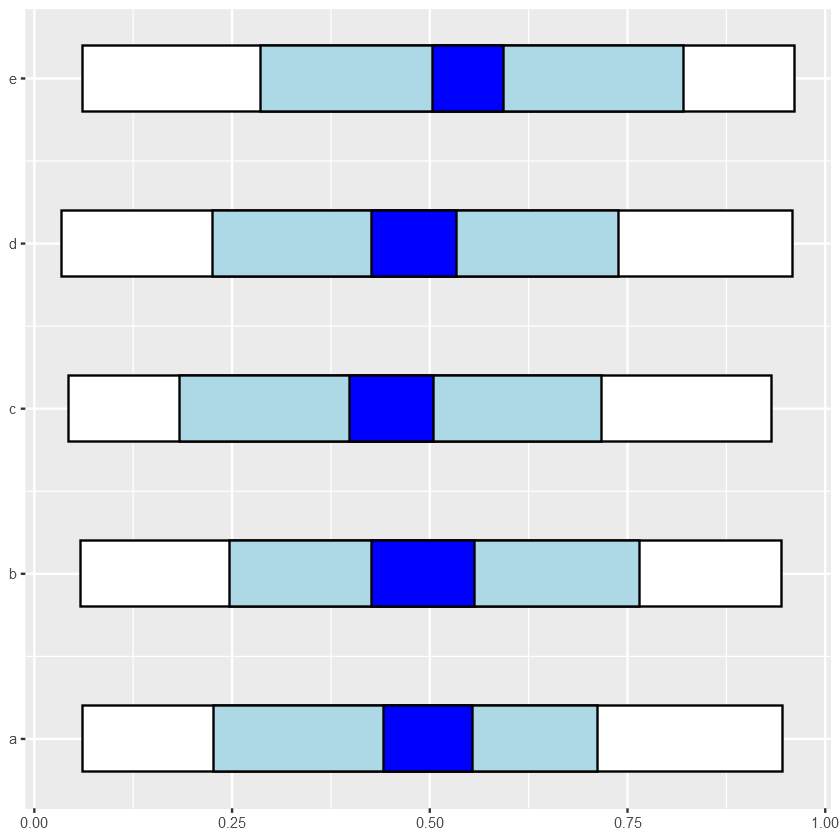

In [102]:
ggplot(datSum,aes(ymin = NameAlt - 0.2,ymax = NameAlt + 0.2)) + 
    geom_rect(aes(xmin = q05,xmax = q95),fill = "white",colour = "black") + 
    geom_rect(aes(xmin = q25,xmax = q75),fill = 'lightblue',colour = "black") +
    geom_rect(aes(xmin = q45,xmax = q55),fill = 'blue',colour = "black") +
    scale_y_continuous(breaks = 1:5,labels = datSum$Name)

In [148]:
write.table(gene_priority,"../../ANALYSIS/GENE_PRIORITY/TRANS_GENE_PRIORITY_NM.TAB",row.names=FALSE,quote=FALSE,sep="\t")

In [568]:
top3_genes <- gene_priority%>%group_by(WINDOW) %>% slice_max(order_by = GP_SCORE, n = 3)

In [569]:
write.table(top3_genes,"../../ANALYSIS/GENE_PRIORITY/TRANS_GENE_PRIORITY_NMTOP3.TAB",row.names=FALSE,quote=FALSE,sep="\t")